--- Kiểm tra và cấu hình GPU ---
✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.
------------------------------

🧹 Đang cố gắng dọn dẹp bộ nhớ...
✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.

✅ Đã tìm thấy các file .npz trong 'E:/tmp_sliding_chunks' và scaler chung trong 'E:/tmp_scalers'. Đang tải...
✅ Đã tải các scaler chung từ 'E:/tmp_scalers'.
✅ Đã tìm thấy 109 file .npz. Đang tải dữ liệu...

⏳ Đang đếm tổng số mẫu từ các file NPZ...
✅ Tổng số mẫu được tải: 905484

📊 Tổng số mẫu: 905484
📚 Số samples cho tập Train: 543232 (khoảng 4244 batches)
🧪 Số samples cho tập Validation: 180992 (khoảng 1414 batches)
🎯 Số samples cho tập Test: 181260 (số lượng thực tế sẽ là 180992 nếu batching đến hết hoặc nhỏ hơn nếu batch cuối cùng)
✅ Hoàn thành chia tập dữ liệu.

🚀 Bắt đầu huấn luyện mô hình GRU Encoder-Decoder...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output 

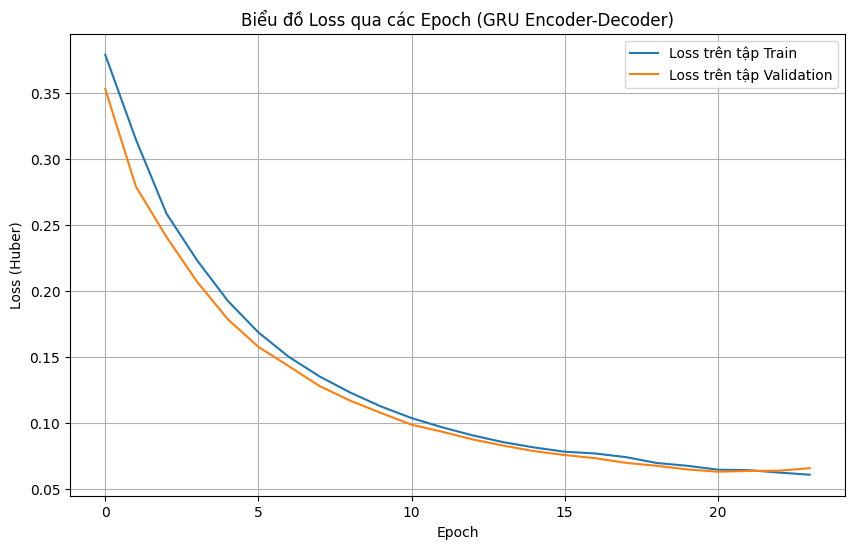

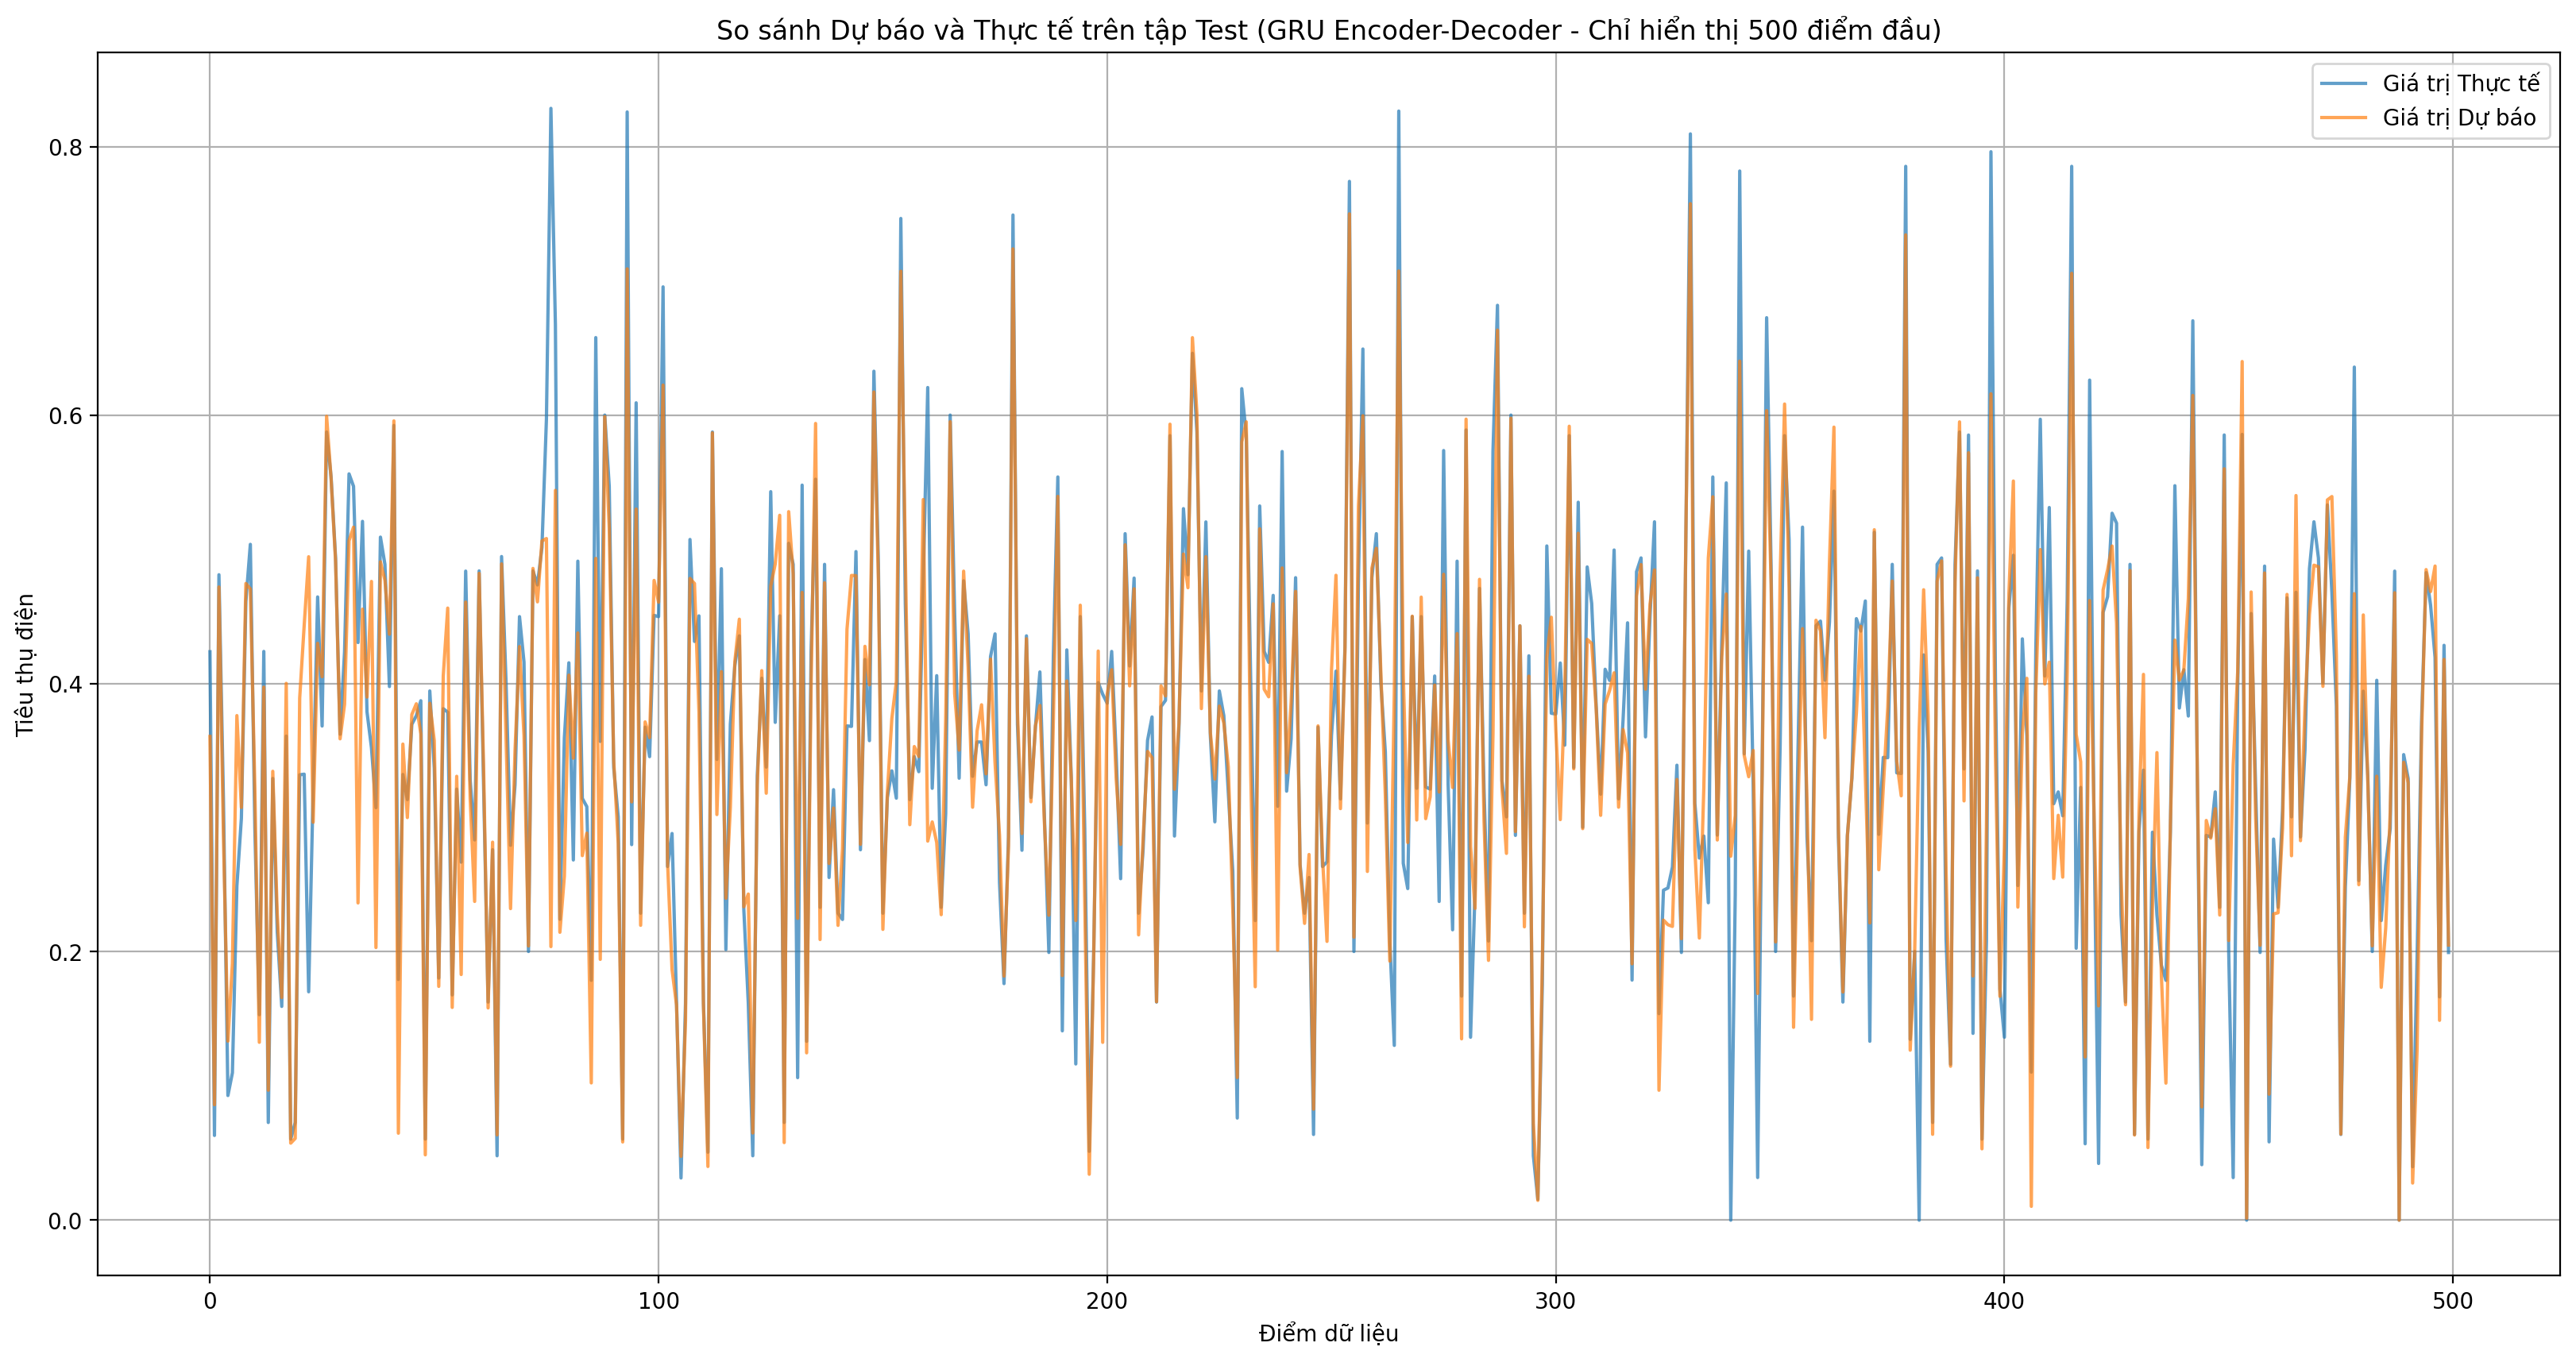

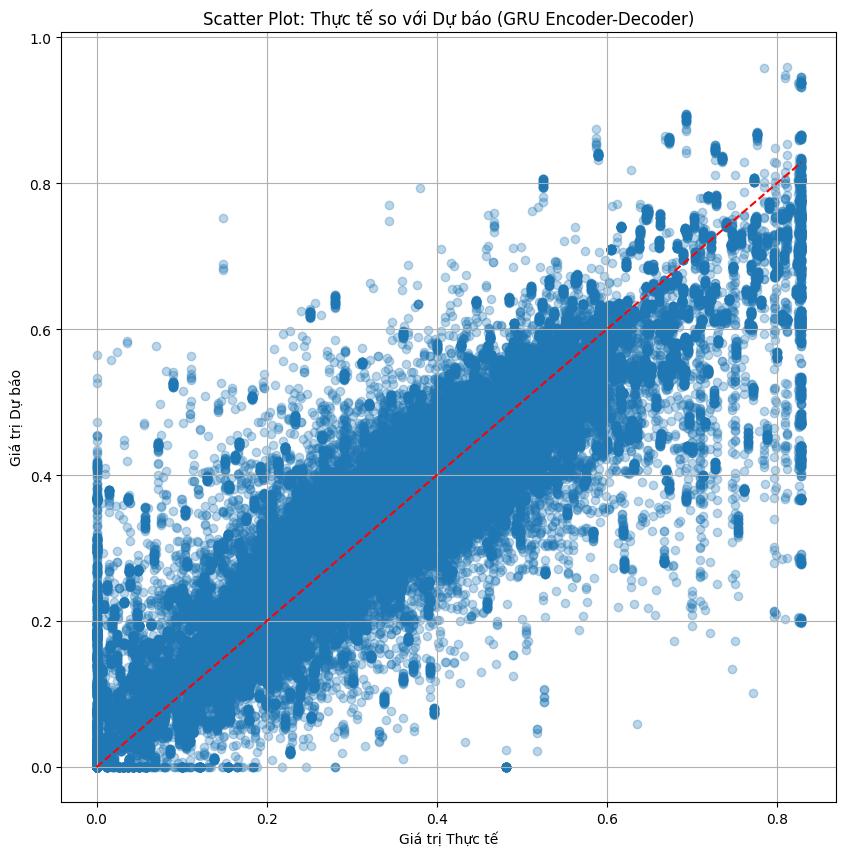


Tổng thời gian chạy toàn bộ pipeline (GRU Encoder-Decoder): 4376.23 giây


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, Dense, Input, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gc
import joblib

print("--- Kiểm tra và cấu hình GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")
print("------------------------------")


FILE_PATH = 'C:/CODE/Python/11gb_data.csv' 


TEMP_CHUNKS_DIR_COMMON = 'E:/tmp_sliding_chunks' 
SCALER_DIR_COMMON = 'E:/tmp_scalers'

# Tên file trọng số mô hình GRU Encoder-Decoder
GRU_CHECKPOINT_FILE = 'best_model_weights_gru.weights.h5'
GRU_CHECKPOINT_PATH = os.path.join(SCALER_DIR_COMMON, GRU_CHECKPOINT_FILE)

DEFAULT_TARGET_SCALER_FILE = 'target_scaler.pkl'
DEFAULT_FEATURE_SCALER_FILE = 'feature_scaler.pkl'

DEFAULT_TARGET_SCALER_PATH = os.path.join(SCALER_DIR_COMMON, DEFAULT_TARGET_SCALER_FILE)
DEFAULT_FEATURE_SCALER_PATH = os.path.join(SCALER_DIR_COMMON, DEFAULT_FEATURE_SCALER_FILE)

GRU_TARGET_SCALER_SAVED_FILE = 'target_scaler_gru.pkl'
GRU_FEATURE_SCALER_SAVED_FILE = 'feature_scaler_gru.pkl'

GRU_TARGET_SCALER_SAVED_PATH = os.path.join(SCALER_DIR_COMMON, GRU_TARGET_SCALER_SAVED_FILE)
GRU_FEATURE_SCALER_SAVED_PATH = os.path.join(SCALER_DIR_COMMON, GRU_FEATURE_SCALER_SAVED_FILE)


os.makedirs(TEMP_CHUNKS_DIR_COMMON, exist_ok=True)
os.makedirs(SCALER_DIR_COMMON, exist_ok=True)

WINDOW_SIZE = 48
HORIZON = 24
STRIDE = 6

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000

def read_and_resample_chunks(csv_path, chunk_size=100_000):
    all_resampled_data = []
    print(f"📦 Đang bắt đầu quá trình đọc và resample chunk từ file CSV '{csv_path}'...")
    
    custom_dtypes = {
        'Value': np.float32, 
    }
    
    try:
        chunks = pd.read_csv(
            csv_path, 
            parse_dates=['Timestamp'], 
            chunksize=chunk_size,
            low_memory=True,
            dtype=custom_dtypes 
        )
    except Exception as e:
        print(f"❌ Lỗi khi đọc file CSV: {e}")
        print("Gợi ý: Kiểm tra lại tên các cột trong 'custom_dtypes' có khớp với file CSV không.")
        print("Hoặc thử bỏ 'dtype=custom_dtypes' nếu bạn không chắc chắn, nhưng nó có thể dùng nhiều RAM hơn.")
        raise 

    for i, chunk in enumerate(chunks):
        if chunk.empty:
            print(f"Chunk {i} rỗng, bỏ qua.")
            continue
        print(f"⏳ Đang xử lý Chunk {i} ({len(chunk)} dòng)...")
        
        chunk = chunk.set_index('Timestamp').sort_index()

        chunk['hour_sin'] = np.sin(2 * np.pi * chunk.index.hour / 24)
        chunk['hour_cos'] = np.cos(2 * np.pi * chunk.index.hour / 24)
        chunk['dayofweek_sin'] = np.sin(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofweek_cos'] = np.cos(2 * np.pi * chunk.index.dayofweek / 7)
        chunk['dayofyear_sin'] = np.sin(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['dayofyear_cos'] = np.cos(2 * np.pi * chunk.index.dayofyear / 365.25)
        chunk['is_weekend'] = (chunk.index.dayofweek >= 5).astype(int)

        if 'Anomaly_Label' in chunk.columns:
            chunk = chunk.drop(columns=['Anomaly_Label'])
        
        if 'Meter_ID' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID'])
        if 'Meter_ID_Numeric' in chunk.columns:
            chunk = chunk.drop(columns=['Meter_ID_Numeric'])

        numeric_chunk = chunk.select_dtypes(include=[np.number])

        numeric_chunk = numeric_chunk.interpolate(method='time', limit_direction='both')
        resampled_chunk = numeric_chunk.resample('1h').mean()
        resampled_chunk = resampled_chunk.ffill().bfill()
        
        if resampled_chunk.isnull().any().any():
            print(f"Cảnh báo: Chunk {i} vẫn còn giá trị NaN sau khi resample. Đang điền bằng trung bình cột.")
            resampled_chunk = resampled_chunk.fillna(resampled_chunk.mean())

        target_column_name = resampled_chunk.columns[0]
        Q1 = resampled_chunk[target_column_name].quantile(0.01)
        Q99 = resampled_chunk[target_column_name].quantile(0.99)
        resampled_chunk[target_column_name] = np.clip(resampled_chunk[target_column_name], Q1, Q99)
        
        for lag in [1, 24, 24*7]:
            resampled_chunk[f'{target_column_name}_lag_{lag}h'] = resampled_chunk[target_column_name].shift(lag)

        resampled_chunk = resampled_chunk.dropna()

        if not resampled_chunk.empty:
            all_resampled_data.append(resampled_chunk)
        print(f"✅ Hoàn thành xử lý Chunk {i}.")
        gc.collect()

    if not all_resampled_data:
        raise ValueError("Không có dữ liệu hợp lệ nào sau khi xử lý tất cả các chunk.")

    full_resampled_df = pd.concat(all_resampled_data)
    print(f"✅ Đã tổng hợp tất cả dữ liệu resample. Tổng số dòng: {len(full_resampled_df)}")
    gc.collect()
    return full_resampled_df

def sliding_save_chunks(data, input_seq_len, output_seq_len, stride, chunk_size, save_dir):
    total_len = input_seq_len + output_seq_len
    
    num_samples = data.shape[0] - total_len + 1 
    num_full_chunks = num_samples // chunk_size
    
    print(f"📊 Tổng số mẫu có thể tạo: {num_samples}")
    print(f"📦 Sẽ tạo khoảng {num_full_chunks + (1 if num_samples % chunk_size != 0 else 0)} file .npz.")

    current_idx = 0
    chunk_file_idx = 0

    while current_idx < num_samples:
        start_chunk_idx = current_idx
        end_chunk_idx = min(current_idx + chunk_size, num_samples)
        
        X_chunk_list = []
        y_chunk_list = []

        for j in range(start_chunk_idx, end_chunk_idx, stride):
            if j + total_len <= data.shape[0]:
                X_sample = data[j : j + input_seq_len]
                y_sample = data[j + input_seq_len : j + total_len, 0]
                X_chunk_list.append(X_sample)
                y_chunk_list.append(y_sample)
            else:
                break

        if X_chunk_list:
            X_chunk_arr = np.array(X_chunk_list, dtype=np.float32)
            y_chunk_arr = np.array(y_chunk_list, dtype=np.float32)
            
            save_path = f"{save_dir}/chunk_{chunk_file_idx}.npz"
            np.savez(save_path, X=X_chunk_arr, y=y_chunk_arr)
            print(f"    💾 Đã lưu {X_chunk_arr.shape[0]} mẫu vào '{save_path}'")
            chunk_file_idx += 1
        
        current_idx = end_chunk_idx

        del X_chunk_list, y_chunk_list, X_chunk_arr, y_chunk_arr
        gc.collect()

def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X']
        y = data['y']
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(
                    tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32), 
                    tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32)
                )
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    def prepare_encoder_decoder_dataset(X, y_true):
        encoder_input = X
        decoder_input = tf.zeros_like(y_true, dtype=tf.float32)
        decoder_input = tf.expand_dims(decoder_input, axis=-1)
        true_output = tf.expand_dims(y_true, axis=-1)
        
        return (encoder_input, decoder_input), true_output

    dataset = dataset.map(prepare_encoder_decoder_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# ĐỊNH NGHĨA MÔ HÌNH GRU ENCODER-DECODER
def create_gru_encoder_decoder_model(
    input_seq_len,
    output_seq_len,
    num_encoder_features,
    num_decoder_features=1,
    gru_units=128,
    l2_reg=1e-3
):
    encoder_inputs = Input(shape=(input_seq_len, num_encoder_features), name='encoder_inputs')
    
    encoder_gru = GRU(gru_units, return_state=True, kernel_regularizer=l2(l2_reg))
    encoder_outputs, state_h = encoder_gru(encoder_inputs)
    
    decoder_inputs = Input(shape=(output_seq_len, num_decoder_features), name='decoder_inputs')
    
    decoder_gru = GRU(gru_units, return_sequences=True, kernel_regularizer=l2(l2_reg))
    decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
    
    output_predictions = TimeDistributed(Dense(1, activation='linear'))(decoder_outputs)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output_predictions)
    return model


if __name__ == '__main__':
    start_time_full_process = time.time()
    
    print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ...")
    tf.keras.backend.clear_session() 
    gc.collect() 
    print("✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.")

    existing_npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz'))
    
    default_target_scaler_exists = os.path.exists(DEFAULT_TARGET_SCALER_PATH)
    default_feature_scaler_exists = os.path.exists(DEFAULT_FEATURE_SCALER_PATH)

    if not existing_npz_files or not (default_target_scaler_exists and default_feature_scaler_exists):
        print("\n⚠️ Không tìm thấy đầy đủ các file NPZ HOẶC Scaler chung trong thư mục.")
        print("⏳ Đang tiến hành tiền xử lý dữ liệu và tạo file. Quá trình này có thể tốn nhiều thời gian...")
        
        resampled_df = read_and_resample_chunks(FILE_PATH) 
        
        target_column_name = resampled_df.columns[0]

        selected_features = [
            target_column_name,
            f'{target_column_name}_lag_1h',
            f'{target_column_name}_lag_24h',
            f'{target_column_name}_lag_168h', 
            'hour_sin',
            'hour_cos',
            'dayofweek_sin',
            'dayofweek_cos',
            'dayofyear_sin', 
            'dayofyear_cos', 
            'is_weekend',
        ]

        existing_selected_features = [col for col in selected_features if col in resampled_df.columns]
        if 'Temperature' not in resampled_df.columns and 'Temperature' in selected_features:
            print("⚠️ Cảnh báo: Cột 'Temperature' không tồn tại trong dữ liệu sau resample và sẽ bị bỏ qua.")

        data_for_scaling = resampled_df[existing_selected_features].values
        print(f"📊 Dữ liệu sau tiền xử lý và chọn đặc trưng: shape {data_for_scaling.shape}")

        print("💡 Đang fit và transform scaler toàn cục...")
        target_scaler = StandardScaler()
        feature_scaler = StandardScaler()

        target_scaled = target_scaler.fit_transform(data_for_scaling[:, 0].reshape(-1, 1))
        features_scaled = feature_scaler.fit_transform(data_for_scaling[:, 1:])

        data_scaled = np.concatenate((target_scaled, features_scaled), axis=1)
        print("✅ Hoàn thành chuẩn hóa dữ liệu.")
        
        joblib.dump(target_scaler, DEFAULT_TARGET_SCALER_PATH)
        joblib.dump(feature_scaler, DEFAULT_FEATURE_SCALER_PATH)
        print(f"✅ Đã lưu các scaler chung vào '{SCALER_DIR_COMMON}'.")

        print(f"\n💾 Đang tạo và lưu sliding windows vào thư mục: {TEMP_CHUNKS_DIR_COMMON}...")
        SLIDING_CHUNK_SIZE = 50_000 
        sliding_save_chunks(data_scaled, WINDOW_SIZE, HORIZON, stride=STRIDE, 
                            chunk_size=SLIDING_CHUNK_SIZE, save_dir=TEMP_CHUNKS_DIR_COMMON) 
        print(f"✅ Hoàn thành tạo và lưu sliding windows vào '{TEMP_CHUNKS_DIR_COMMON}'.")
        
        del resampled_df, data_for_scaling, target_scaled, features_scaled, data_scaled
        gc.collect()

    else:
        print(f"\n✅ Đã tìm thấy các file .npz trong '{TEMP_CHUNKS_DIR_COMMON}' và scaler chung trong '{SCALER_DIR_COMMON}'. Đang tải...")
        try:
            target_scaler = joblib.load(DEFAULT_TARGET_SCALER_PATH)
            feature_scaler = joblib.load(DEFAULT_FEATURE_SCALER_PATH)
            print(f"✅ Đã tải các scaler chung từ '{SCALER_DIR_COMMON}'.")
        except Exception as e:
            print(f"❌ Lỗi khi tải scaler chung: {e}. Vui lòng kiểm tra '{SCALER_DIR_COMMON}' hoặc chạy lại tiền xử lý.")
            exit()

    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz')) 
    if not npz_files:
        print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR_COMMON}'. Vui lòng kiểm tra đường dẫn hoặc chạy lại tiền xử lý.")
        exit()

    print(f"✅ Đã tìm thấy {len(npz_files)} file .npz. Đang tải dữ liệu...")
    
    sample_data = np.load(npz_files[0])
    sample_X_shape = sample_data['X'].shape
    num_features_in_npz = sample_X_shape[-1]
    del sample_data, sample_X_shape 

    full_dataset_from_npz = load_npz_dataset(npz_files, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                                             shuffle=True)
    
    print("\n⏳ Đang đếm tổng số mẫu từ các file NPZ...")
    total_samples = 0
    for filepath in npz_files:
        data = np.load(filepath)
        total_samples += data['X'].shape[0]
        data.close()
    print(f"✅ Tổng số mẫu được tải: {total_samples}")
    
    train_size = int(0.6 * total_samples)
    val_size = int(0.2 * total_samples)
    test_size = total_samples - train_size - val_size

    train_batches = train_size // BATCH_SIZE
    val_batches = val_size // BATCH_SIZE
    test_batches = test_size // BATCH_SIZE

    train_dataset = full_dataset_from_npz.take(train_batches)
    val_dataset = full_dataset_from_npz.skip(train_batches).take(val_batches)
    test_dataset = full_dataset_from_npz.skip(train_batches + val_batches) 

    print(f"\n📊 Tổng số mẫu: {total_samples}")
    print(f"📚 Số samples cho tập Train: {train_batches * BATCH_SIZE} (khoảng {train_batches} batches)")
    print(f"🧪 Số samples cho tập Validation: {val_batches * BATCH_SIZE} (khoảng {val_batches} batches)")
    print(f"🎯 Số samples cho tập Test: {total_samples - (train_batches * BATCH_SIZE) - (val_batches * BATCH_SIZE)} (số lượng thực tế sẽ là {test_batches * BATCH_SIZE} nếu batching đến hết hoặc nhỏ hơn nếu batch cuối cùng)")
    print("✅ Hoàn thành chia tập dữ liệu.")

    print("\n🚀 Bắt đầu huấn luyện mô hình GRU Encoder-Decoder...")
    start_train = time.time()

    num_features = num_features_in_npz 
    num_decoder_features = 1 

    model = create_gru_encoder_decoder_model(
        input_seq_len=WINDOW_SIZE,
        output_seq_len=HORIZON,
        num_encoder_features=num_features,
        num_decoder_features=num_decoder_features,
        gru_units=128,
        l2_reg=1e-3
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0), # Nên giữ clipnorm để ổn định huấn luyện
        loss=tf.keras.losses.Huber(), 
        metrics=['mae']
    )
    model.summary() 

    checkpoint_filepath = GRU_CHECKPOINT_PATH 
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7), 
        ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50, 
        callbacks=callbacks,
        verbose=1
    )

    print(f"✅ Huấn luyện hoàn tất sau {time.time() - start_train:.2f} giây")

    try:
        joblib.dump(target_scaler, GRU_TARGET_SCALER_SAVED_PATH)
        joblib.dump(feature_scaler, GRU_FEATURE_SCALER_SAVED_PATH)
        print(f"✅ Đã lưu các scaler được sử dụng cho GRU vào '{SCALER_DIR_COMMON}' với hậu tố '_gru'.")
    except Exception as e:
        print(f"❌ Lỗi khi lưu scaler GRU sau huấn luyện: {e}")


    try:
        model.load_weights(checkpoint_filepath)
        print(f"✅ Đã tải lại trọng số tốt nhất cho GRU từ '{checkpoint_filepath}'")
    except Exception as e:
        print(f"⚠️ Không tìm thấy trọng số tốt nhất cho GRU để tải lại hoặc có lỗi: {e}")
        print("Mô hình GRU sẽ tiếp tục với trọng số cuối cùng của quá trình huấn luyện.")

    print("\n📈 Đang dự báo trên tập test (GRU Encoder-Decoder)...")
    start_test = time.time()
    
    y_true_list = []
    y_pred_list = []

    for (X_batch, decoder_input_batch), y_true_batch in test_dataset: 
        y_pred_batch_scaled = model.predict((X_batch, decoder_input_batch), verbose=0)
        
        y_true_list.append(tf.squeeze(y_true_batch, axis=-1).numpy()) 
        y_pred_list.append(tf.squeeze(y_pred_batch_scaled, axis=-1).numpy()) 

    y_true_all_scaled = np.concatenate(y_true_list, axis=0)
    y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)

    print(f"✅ Dự báo hoàn tất sau {time.time() - start_test:.2f} giây.")

    true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
    predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

    true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
    predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

    predicted[predicted < 0] = 0
    true[true < 0] = 0

    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
        return 100 * np.mean(numerator / denominator)

    print("\n📊 Evaluation on Test Set (GRU Encoder-Decoder):")
    print(f"MAE  = {mean_absolute_error(true, predicted):.4f}")
    print(f"MSE  = {mean_squared_error(true, predicted):.4f}")
    print(f"RMSE = {np.sqrt(mean_squared_error(true, predicted)):.4f}")

    epsilon = 1e-8
    mape = np.mean(np.abs((true - predicted) / (true + epsilon))) * 100
    print(f"MAPE = {mape:.2f}%")
    print(f"sMAPE= {smape(true, predicted):.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss trên tập Train')
    plt.plot(history.history['val_loss'], label='Loss trên tập Validation')
    plt.title('Biểu đồ Loss qua các Epoch (GRU Encoder-Decoder)') 
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Huber)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 10), dpi=200)
    sample_size = 500
    plot_true = true[:sample_size] if len(true) >= sample_size else true
    plot_predicted = predicted[:sample_size] if len(predicted) >= sample_size else predicted

    plt.plot(plot_true, label='Giá trị Thực tế', alpha=0.7)
    plt.plot(plot_predicted, label='Giá trị Dự báo', alpha=0.7)
    plt.legend()
    plt.title(f'So sánh Dự báo và Thực tế trên tập Test (GRU Encoder-Decoder - Chỉ hiển thị {len(plot_true)} điểm đầu)')
    plt.xlabel('Điểm dữ liệu')
    plt.ylabel('Tiêu thụ điện')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.scatter(true, predicted, alpha=0.3)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự báo')
    plt.title('Scatter Plot: Thực tế so với Dự báo (GRU Encoder-Decoder)') 
    plt.grid(True)
    plt.show()

    print(f"\nTổng thời gian chạy toàn bộ pipeline (GRU Encoder-Decoder): {time.time() - start_time_full_process:.2f} giây")

In [ ]:
import numpy as np
import tensorflow as tf
import os
import glob
import joblib 

# --- Kiểm tra và cấu hình GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động. Có thể GPU đã được khởi tạo.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")

# --- HẰNG SỐ VÀ ĐƯỜNG DẪN ---
TEMP_CHUNKS_DIR_COMMON = 'E:/tmp_sliding_chunks' 
SCALER_DIR_COMMON = 'E:/tmp_scalers'

GRU_CHECKPOINT_FILE = 'best_model_weights_gru.weights.h5'
GRU_CHECKPOINT_PATH = os.path.join(SCALER_DIR_COMMON, GRU_CHECKPOINT_FILE)

GRU_FULL_MODEL_SAVE_FILE = 'gru_full_model.h5'
GRU_FULL_MODEL_SAVE_PATH = os.path.join(SCALER_DIR_COMMON, GRU_FULL_MODEL_SAVE_FILE)

WINDOW_SIZE = 48
HORIZON = 24

# --- ĐỊNH NGHĨA MÔ HÌNH GRU ENCODER-DECODER (SỬ DỤNG HÀM FUNCTIONAL API CỦA BẠN) ---
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, Dense, Input, TimeDistributed
from tensorflow.keras.models import Model # Cần import Model ở đây

def create_gru_encoder_decoder_model(
    input_seq_len,
    output_seq_len,
    num_encoder_features,
    num_decoder_features=1,
    gru_units=128,
    l2_reg=1e-3
):
    encoder_inputs = Input(shape=(input_seq_len, num_encoder_features), name='encoder_inputs')
    
    encoder_gru = GRU(gru_units, return_state=True, kernel_regularizer=l2(l2_reg))
    encoder_outputs, state_h = encoder_gru(encoder_inputs) # encoder_outputs không được dùng sau đó, chỉ dùng state_h
    
    decoder_inputs = Input(shape=(output_seq_len, num_decoder_features), name='decoder_inputs')
    
    # Decoder GRU nhận initial_state từ encoder và trả về sequence
    decoder_gru = GRU(gru_units, return_sequences=True, kernel_regularizer=l2(l2_reg))
    decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
    
    # TimeDistributed Dense layer để dự đoán mỗi bước trong sequence
    output_predictions = TimeDistributed(Dense(1, activation='linear'))(decoder_outputs)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output_predictions)
    return model

# --- PHẦN CHÍNH CỦA SCRIPT ĐỂ TẢI TRỌNG SỐ VÀ LƯU MÔ HÌNH ---

if __name__ == '__main__':
    tf.keras.backend.clear_session() 

    print("\n--- Bắt đầu quá trình xuất mô hình GRU Encoder-Decoder ---")

    # 1. Xác định num_encoder_features
    npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR_COMMON, '*.npz')) 
    if not npz_files:
        print(f"❌ Lỗi: Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR_COMMON}'.")
        print("Vui lòng đảm bảo các file NPZ đã được tạo bởi quá trình tiền xử lý/huấn luyện GRU.")
        exit()

    sample_data = np.load(npz_files[0])
    num_encoder_features = sample_data['X'].shape[-1]
    sample_data.close() 
    print(f"📈 Số lượng đặc trưng đầu vào (num_encoder_features) được xác định: {num_encoder_features}")

    # 2. Khởi tạo mô hình GRUEncoderDecoder với cấu trúc chính xác
    # CÁC THAM SỐ NÀY PHẢI KHỚP CHÍNH XÁC VỚI MÔ HÌNH BẠN ĐÃ HUẤN LUYỆN
    GRU_RNN_UNITS = 128 
    GRU_NUM_LAYERS = 2  
    
    # Hiện tại, các biến GRU_RNN_UNITS và HORIZON là quan trọng nhất để khớp.
    
    model = create_gru_encoder_decoder_model(
        input_seq_len=WINDOW_SIZE,
        output_seq_len=HORIZON,
        num_encoder_features=num_encoder_features,
        num_decoder_features=1, # Luôn là 1 cho output của decoder TimeDistributed(Dense(1))
        gru_units=GRU_RNN_UNITS,
        l2_reg=1e-3
    )
    
    model.summary() 
    print("✅ Đã khởi tạo mô hình GRU với cấu trúc.")

    # 3. Tải trọng số vào mô hình
    if not os.path.exists(GRU_CHECKPOINT_PATH):
        print(f"❌ Lỗi: File trọng số '{GRU_CHECKPOINT_PATH}' không tồn tại. Không thể tải trọng số.")
        print("Vui lòng kiểm tra lại đường dẫn hoặc đảm bảo bạn đã huấn luyện và lưu trọng số GRU.")
        exit()

    try:
        model.load_weights(GRU_CHECKPOINT_PATH)
        print(f"✅ Đã tải trọng số từ '{GRU_CHECKPOINT_PATH}' vào mô hình GRU.")
    except Exception as e:
        print(f"❌ Lỗi khi tải trọng số GRU: {e}")
        print("Vui lòng kiểm tra lại cấu trúc mô hình (gru_units, l2_reg) và đảm bảo nó khớp chính xác với trọng số.")
        exit()

    # 4. Lưu toàn bộ mô hình (cấu trúc + trọng số)
    try:
        model.save(GRU_FULL_MODEL_SAVE_PATH)
        print(f"✅ Đã lưu toàn bộ mô hình GRU (cấu trúc + trọng số) vào '{GRU_FULL_MODEL_SAVE_PATH}'")
    except Exception as e:
        print(f"❌ Lỗi khi lưu toàn bộ mô hình GRU: {e}")
        print("Có thể do quyền truy cập thư mục hoặc các vấn đề với TensorFlow.")

    print("\n--- Hoàn tất quá trình xuất mô hình GRU Encoder-Decoder ---")

✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.

--- Bắt đầu quá trình xuất mô hình GRU Encoder-Decoder ---
📈 Số lượng đặc trưng đầu vào (num_encoder_features) được xác định: 11
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 48, 11)]     0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 24, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      [(None, 128),        54144       ['encoder_inputs[0][0]']         
                                 (None, 128)]                             

--- Khởi tạo và chuẩn bị môi trường ---
✅ Phát hiện 1 Physical GPUs, 1 Logical GPUs.
💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.
-------------------------------------------------
✅ Đã định nghĩa tất cả các hàm và lớp.

🧹 Đang cố gắng dọn dẹp bộ nhớ TensorFlow...
✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.

--- Đang tải scaler, mô hình GRU và chạy dự báo ---
✅ Đã tải các scaler từ file.
📈 Số lượng đặc trưng (num_features) được tự động phát hiện: 11
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 48, 11)]     0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 24, 1)]      0           []                               
                                                 

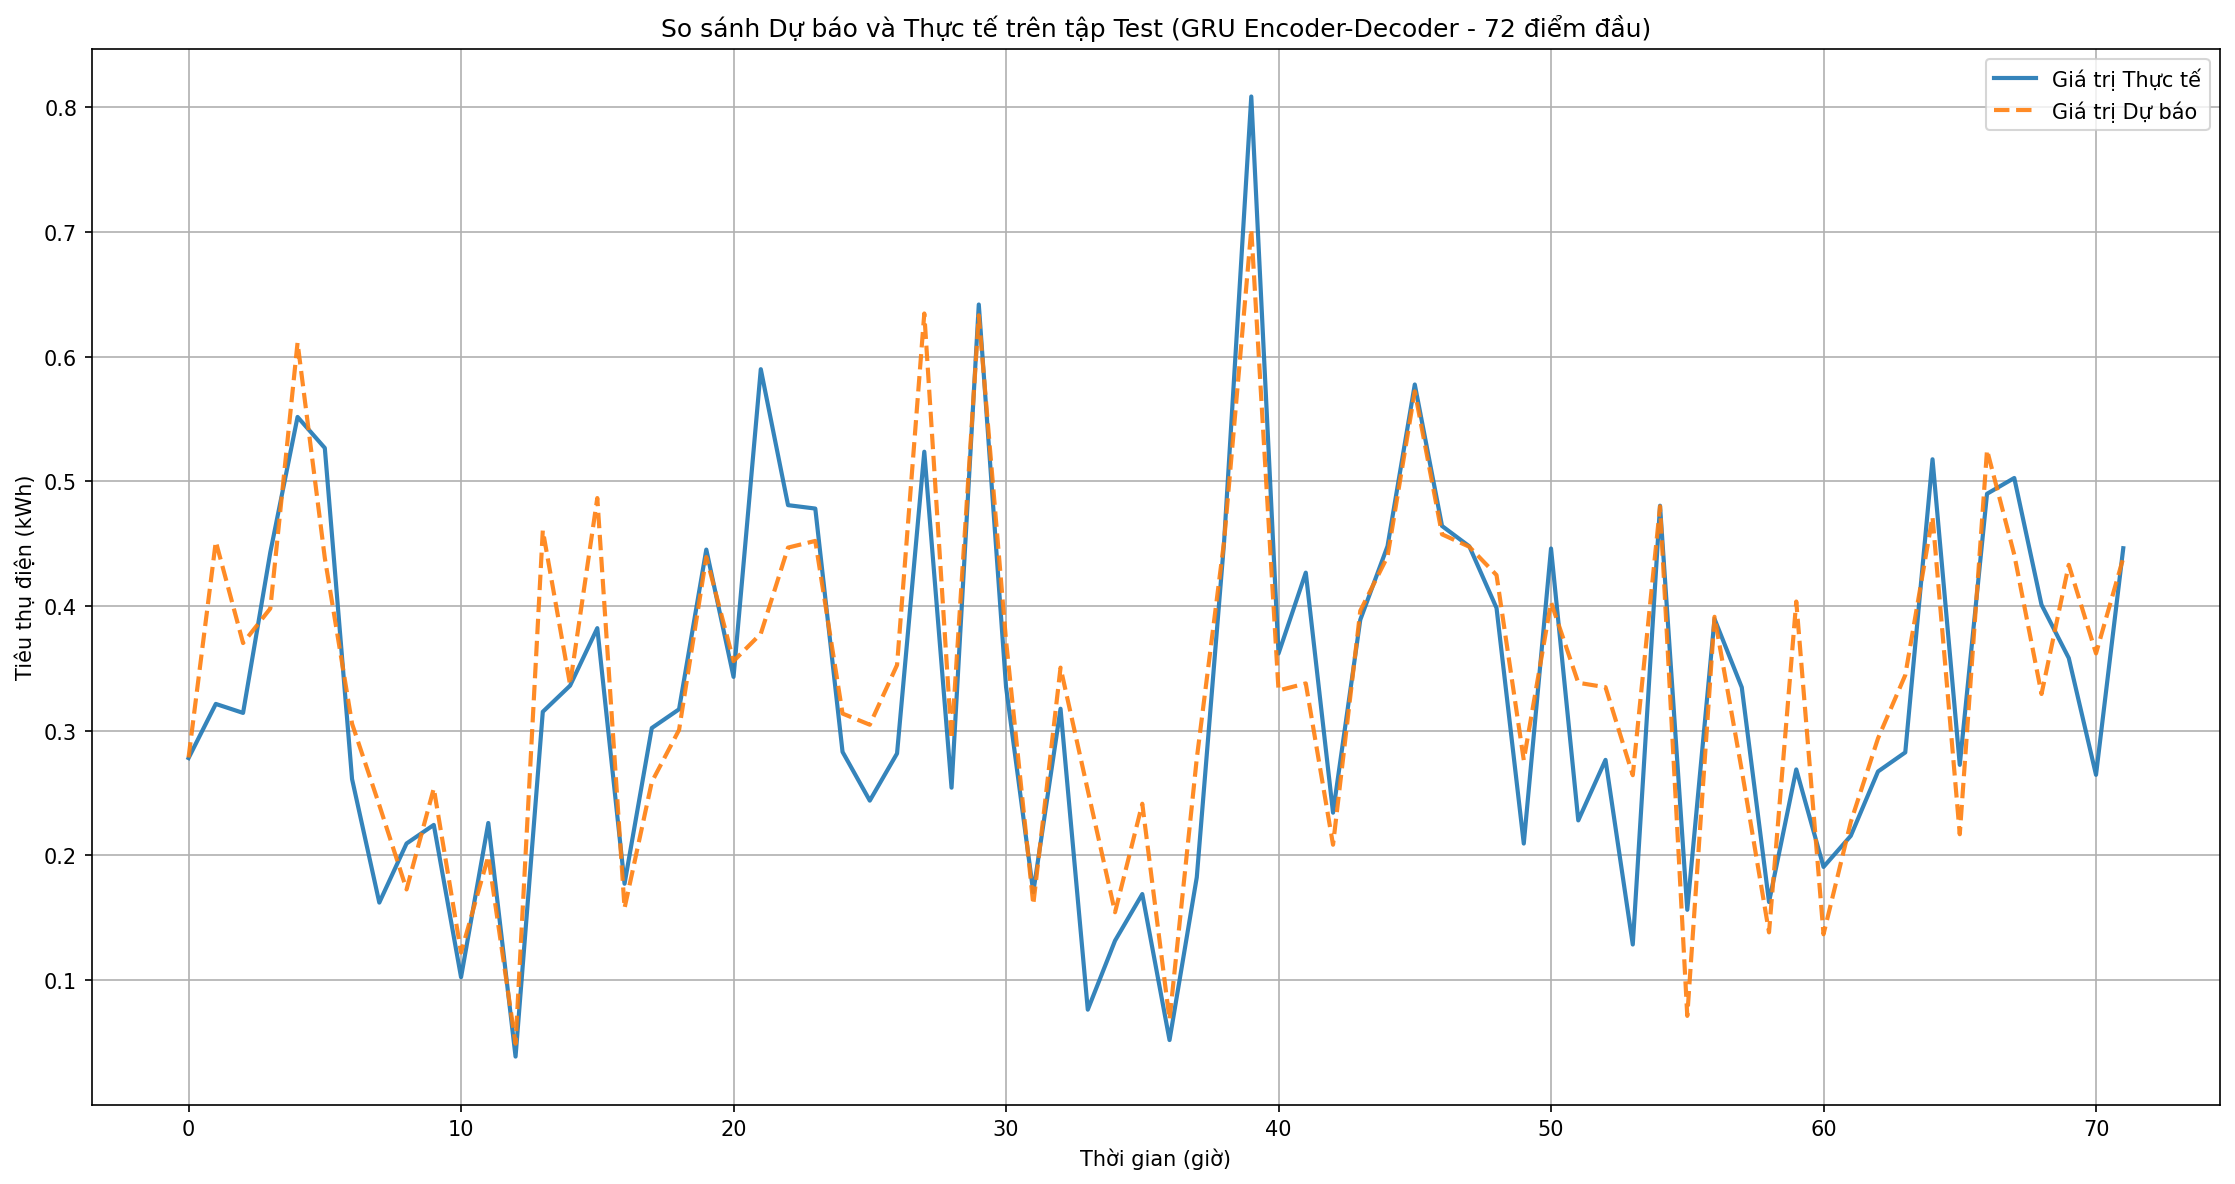

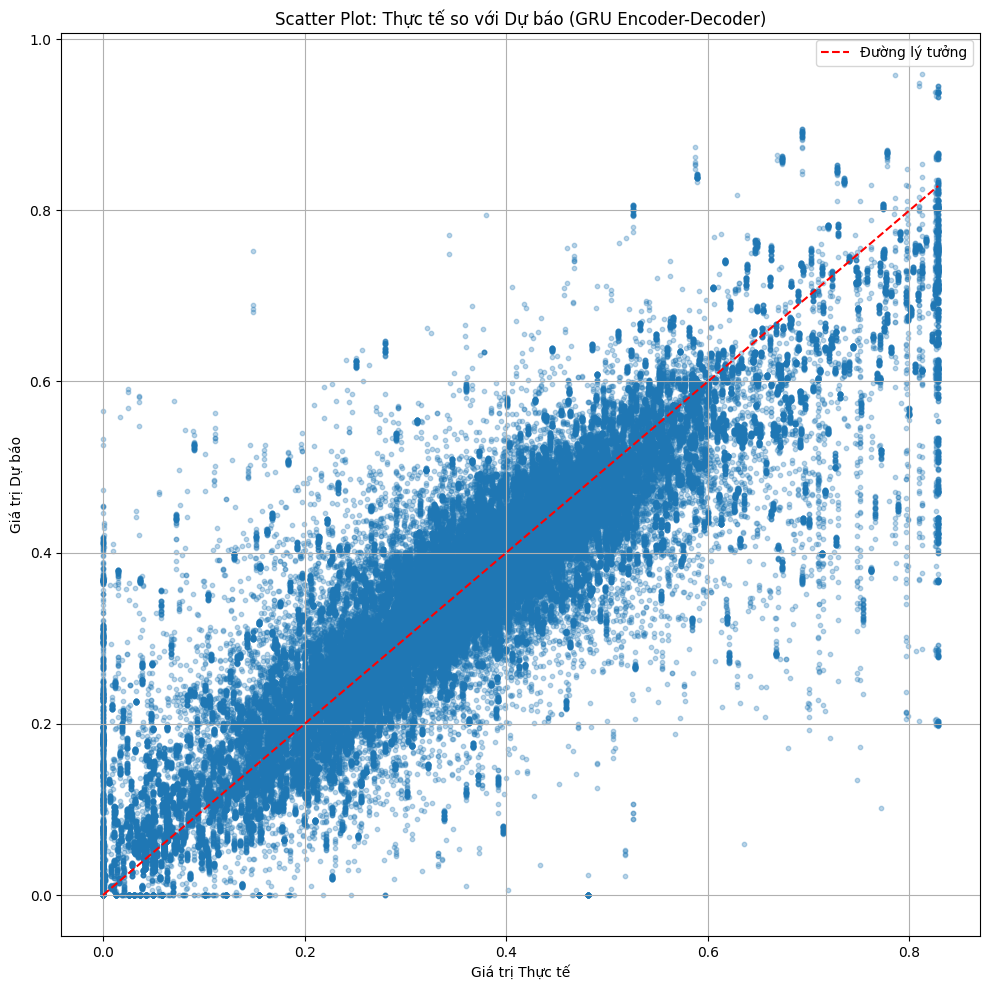


--- Hoàn tất quá trình vẽ biểu đồ ---


In [4]:
import numpy as np
import pandas as pd # Giữ lại pandas mặc dù không dùng trực tiếp để tương thích nếu bạn có các hàm tiền xử lý cũ
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import glob
from sklearn.preprocessing import StandardScaler # Chỉ cần StandardScaler cho scaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, Dense, Input, TimeDistributed # Import các lớp cho GRU
from tensorflow.keras.models import Model # Import Model cho Functional API
import gc
import joblib

print("--- Khởi tạo và chuẩn bị môi trường ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Phát hiện {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
        print("💡 Đã cấu hình bộ nhớ GPU tăng trưởng động.")
    except RuntimeError as e:
        print(e)
        print("❌ Không thể cấu hình bộ nhớ GPU tăng trưởng động.")
else:
    print("⚠️ Không tìm thấy GPU. TensorFlow sẽ chạy trên CPU.")
print("-------------------------------------------------")

# --- HẰNG SỐ (Đảm bảo khớp với cài đặt huấn luyện của bạn) ---
TEMP_CHUNKS_DIR = 'E:/tmp_sliding_chunks'
SCALER_DIR = 'E:/tmp_scalers' # Nơi các scaler và trọng số GRU được lưu
WINDOW_SIZE = 48
HORIZON = 24
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000 

# --- CÁC ĐƯỜNG DẪN CỤ THỂ CHO GRU ---
GRU_CHECKPOINT_FILE = 'best_model_weights_gru.weights.h5'
GRU_CHECKPOINT_PATH = os.path.join(SCALER_DIR, GRU_CHECKPOINT_FILE)

# --- Định nghĩa các hàm và lớp cần thiết ---

def load_npz_dataset(filepaths, batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, shuffle=True):
    def _load_npz_data_and_create_dataset(filepath_tensor):
        filepath_str = filepath_tensor.numpy().decode('utf-8')
        data = np.load(filepath_str)
        X = data['X'] # (WINDOW_SIZE, num_features)
        y = data['y'] # (HORIZON,)
        return tf.data.Dataset.from_tensor_slices((X, y))

    files_ds = tf.data.Dataset.from_tensor_slices(filepaths)

    # DatasetSpec để Keras biết kiểu dữ liệu và hình dạng mong đợi
    element_spec_x = tf.TensorSpec(shape=(WINDOW_SIZE, None), dtype=tf.float32) 
    element_spec_y = tf.TensorSpec(shape=(HORIZON,), dtype=tf.float32)

    dataset = files_ds.interleave(
        lambda filepath: tf.py_function(
            func=_load_npz_data_and_create_dataset,
            inp=[filepath],
            Tout=tf.data.DatasetSpec(
                element_spec=(element_spec_x, element_spec_y)
            )
        ),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size) 
    
    # Hàm prepare_encoder_decoder_dataset để chuyển đổi sang format input cho GRU Functional API
    def prepare_encoder_decoder_dataset(X, y_true):
        encoder_input = X # X là input cho encoder (shape: (WINDOW_SIZE, num_features))
        
        # Decoder input: Một vector zero (hoặc giá trị khởi tạo) có chiều dài HORIZON
        # và 1 feature (vì dự đoán từng bước output)
        decoder_input = tf.zeros_like(y_true, dtype=tf.float32) 
        decoder_input = tf.expand_dims(decoder_input, axis=-1) # Thêm chiều feature (shape: (HORIZON, 1))
        
        # True output: y_true cũng cần được mở rộng chiều feature để khớp với output của decoder
        true_output = tf.expand_dims(y_true, axis=-1) # (shape: (HORIZON, 1))
        
        return (encoder_input, decoder_input), true_output

    dataset = dataset.map(prepare_encoder_decoder_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# --- ĐỊNH NGHĨA MÔ HÌNH GRU ENCODER-DECODER (SỬ DỤNG FUNCTIONAL API) ---
def create_gru_encoder_decoder_model(
    input_seq_len,
    output_seq_len,
    num_encoder_features,
    num_decoder_features=1, # Mặc định là 1 cho input của decoder (ví dụ: zero vector)
    gru_units=128,
    l2_reg=1e-3
):
    # Encoder
    encoder_inputs = Input(shape=(input_seq_len, num_encoder_features), name='encoder_inputs')
    encoder_gru = GRU(gru_units, return_state=True, kernel_regularizer=l2(l2_reg))
    encoder_outputs, state_h = encoder_gru(encoder_inputs) # GRU chỉ có một state (state_h)
    
    # Decoder
    decoder_inputs = Input(shape=(output_seq_len, num_decoder_features), name='decoder_inputs')
    decoder_gru = GRU(gru_units, return_sequences=True, kernel_regularizer=l2(l2_reg))
    decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h) # Truyền state_h của encoder vào decoder
    
    # Lớp TimeDistributed Dense để dự đoán mỗi bước trong sequence
    output_predictions = TimeDistributed(Dense(1, activation='linear'))(decoder_outputs)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output_predictions)
    return model

def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8
    return 100 * np.mean(numerator / denominator)

print("✅ Đã định nghĩa tất cả các hàm và lớp.")

# --- Dọn dẹp bộ nhớ và tải lại các thành phần đã lưu ---
print("\n🧹 Đang cố gắng dọn dẹp bộ nhớ TensorFlow...")
tf.keras.backend.clear_session() 
gc.collect() 
print("✅ Đã hoàn tất dọn dọn dẹp bộ nhớ.")

print(f"\n--- Đang tải scaler, mô hình GRU và chạy dự báo ---")

# Tải lại scaler
target_scaler = None
feature_scaler = None
try:
    target_scaler = joblib.load(os.path.join(SCALER_DIR, 'target_scaler.pkl'))
    feature_scaler = joblib.load(os.path.join(SCALER_DIR, 'feature_scaler.pkl'))
    print("✅ Đã tải các scaler từ file.")
except Exception as e:
    print(f"❌ Lỗi khi tải scaler: {e}. Đảm bảo đường dẫn '{SCALER_DIR}' và các file .pkl tồn tại.")
    print("Vui lòng chạy lại toàn bộ quá trình tiền xử lý và huấn luyện nếu các file này bị thiếu.")
    exit() # Thoát nếu không thể tải scaler

npz_files = glob.glob(os.path.join(TEMP_CHUNKS_DIR, '*.npz'))
if not npz_files:
    print(f"❌ Không tìm thấy file NPZ nào trong '{TEMP_CHUNKS_DIR}'. Vui lòng kiểm tra đường dẫn.")
    print("Vui lòng chạy lại toàn bộ quá trình tiền xử lý và huấn luyện nếu các file này bị thiếu.")
    exit() # Thoát nếu không tìm thấy file NPZ

# Xác định num_features bằng cách tải một file NPZ mẫu
sample_data = np.load(npz_files[0])
num_features = sample_data['X'].shape[-1]
sample_data.close() 
print(f"📈 Số lượng đặc trưng (num_features) được tự động phát hiện: {num_features}")

# Khởi tạo mô hình GRU và tải trọng số
# CÁC THAM SỐ NÀY PHẢI KHỚP CHÍNH XÁC VỚI MÔ HÌNH BẠN ĐÃ HUẤN LUYỆN
GRU_RNN_UNITS = 128 # Số units trong GRU
# num_decoder_features mặc định là 1 trong hàm create_gru_encoder_decoder_model
# l2_reg mặc định là 1e-3 trong hàm create_gru_encoder_decoder_model

model = create_gru_encoder_decoder_model(
    input_seq_len=WINDOW_SIZE,
    output_seq_len=HORIZON,
    num_encoder_features=num_features,
    gru_units=GRU_RNN_UNITS
)

# In ra tóm tắt để xác nhận cấu trúc
model.summary() 
print("✅ Đã khởi tạo mô hình GRU với cấu trúc.")

# Tải trọng số
if not os.path.exists(GRU_CHECKPOINT_PATH):
    print(f"❌ Lỗi: File trọng số '{GRU_CHECKPOINT_PATH}' không tồn tại. Không thể tải trọng số.")
    print("Vui lòng kiểm tra lại đường dẫn hoặc đảm bảo bạn đã huấn luyện và lưu trọng số GRU.")
    exit()

try:
    model.load_weights(GRU_CHECKPOINT_PATH)
    print(f"✅ Đã tải trọng số tốt nhất từ '{GRU_CHECKPOINT_PATH}' vào mô hình GRU.")
except Exception as e:
    print(f"⚠️ Lỗi khi tải trọng số mô hình GRU: {e}. Đảm bảo file '{GRU_CHECKPOINT_PATH}' tồn tại và cấu trúc mô hình khớp.")
    print("Dự đoán sẽ không chính xác nếu trọng số không được tải.")
    exit() # Thoát nếu không thể tải trọng số

# Lấy tổng số mẫu để chia dataset (để xác định tập test)
total_samples = 0
for filepath in npz_files:
    data_temp = np.load(filepath)
    total_samples += data_temp['X'].shape[0]
    data_temp.close() 
print(f"✅ Tổng số mẫu được tải (đếm từ file NPZ): {total_samples}")

# Chia kích thước tập dữ liệu
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
# test_size sẽ là phần còn lại

# Tải dataset test (quan trọng: shuffle=False để dữ liệu test giữ nguyên thứ tự thời gian)
print("\n⏳ Đang tải dữ liệu tập Test để dự báo...")
full_dataset_from_npz_for_test = load_npz_dataset(filepaths=npz_files, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False) # KHÔNG SHUFFLE TẬP TEST

test_dataset = full_dataset_from_npz_for_test.skip(train_size // BATCH_SIZE + val_size // BATCH_SIZE)

y_true_list = []
y_pred_list = []

print("\n📈 Đang chạy dự báo trên tập test để lấy dữ liệu cho biểu đồ...")
start_predict_time = time.time()
for (X_batch, decoder_input_batch), y_true_batch in test_dataset:
    # `model.predict` nhận một tuple (encoder_input, decoder_input)
    y_pred_batch_scaled = model.predict((X_batch, decoder_input_batch), verbose=0)
    
    # squeeze để loại bỏ chiều cuối cùng của y (từ (batch, HORIZON, 1) thành (batch, HORIZON))
    y_true_list.append(tf.squeeze(y_true_batch, axis=-1).numpy()) 
    y_pred_list.append(tf.squeeze(y_pred_batch_scaled, axis=-1).numpy()) 

y_true_all_scaled = np.concatenate(y_true_list, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_list, axis=0)
print(f"✅ Dự báo hoàn tất sau {time.time() - start_predict_time:.2f} giây.")

# Lấy giá trị dự báo và thực tế cho bước đầu tiên (điểm dự báo đầu tiên)
true_scaled_first_step = y_true_all_scaled[:, 0].reshape(-1, 1)
predicted_scaled_first_step = y_pred_all_scaled[:, 0].reshape(-1, 1)

# Đảo ngược chuẩn hóa
true = target_scaler.inverse_transform(true_scaled_first_step).flatten()
predicted = target_scaler.inverse_transform(predicted_scaled_first_step).flatten()

# Đảm bảo không có giá trị âm
predicted[predicted < 0] = 0
true[true < 0] = 0

print("✅ Đã tạo biến 'true' và 'predicted' thành công và sẵn sàng để vẽ.")

# --- Tính toán lại các chỉ số đánh giá ---
print("\n📊 Đánh giá trên tập Test (GRU Encoder-Decoder):")
mae = mean_absolute_error(true, predicted)
mse = mean_squared_error(true, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((true - predicted) / (true + 1e-8))) * 100
s_mape = smape(true, predicted) 

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")
print(f"sMAPE= {s_mape:.2f}%")

# Biểu đồ 1: So sánh Dự báo và Thực tế trên tập Test (Chi tiết - 72 điểm đầu)
if 'true' in locals() and 'predicted' in locals():
    plt.figure(figsize=(15, 8), dpi=150)
    
    sample_size_for_detail = 72 # 72 điểm = 3 ngày
    
    plot_true_detail = true[:sample_size_for_detail]
    plot_predicted_detail = predicted[:sample_size_for_detail]

    plt.plot(plot_true_detail, label='Giá trị Thực tế', alpha=0.9, linewidth=2)
    plt.plot(plot_predicted_detail, label='Giá trị Dự báo', alpha=0.9, linestyle='--', linewidth=2)
    plt.legend()
    plt.title(f'So sánh Dự báo và Thực tế trên tập Test (GRU Encoder-Decoder - {len(plot_true_detail)} điểm đầu)')
    plt.xlabel('Thời gian (giờ)')
    plt.ylabel('Tiêu thụ điện (kWh)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Không thể vẽ biểu đồ So sánh Dự báo và Thực tế: Biến 'true' hoặc 'predicted' không tồn tại.")

# Biểu đồ 2: Scatter Plot: Thực tế so với Dự báo
if 'true' in locals() and 'predicted' in locals():
    plt.figure(figsize=(10, 10))
    plt.scatter(true, predicted, alpha=0.3, s=10)
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--', label='Đường lý tưởng')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự báo')
    plt.title('Scatter Plot: Thực tế so với Dự báo (GRU Encoder-Decoder)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Không thể vẽ biểu đồ Scatter Plot: Biến 'true' hoặc 'predicted' không tồn tại.")

print("\n--- Hoàn tất quá trình vẽ biểu đồ ---")